In [96]:
import json
from PIL import Image
import torchvision 
from torchvision.io import read_image 
from torchvision.utils import draw_bounding_boxes 

IMG_1 = read_image("./dataset/GQA/img/1072.jpg")
IMG_2 = read_image("./dataset/GQA/img/1159835.jpg")
IMG_3 = read_image("./dataset/GQA/img/1591896.jpg")

with open("./dataset/GQA/feat/sceneGraphs.json") as json_file:
    SCENE_GRAPH = json.load(json_file)

In [ ]:
torchvision.transforms.ToPILImage()(IMG_2) 

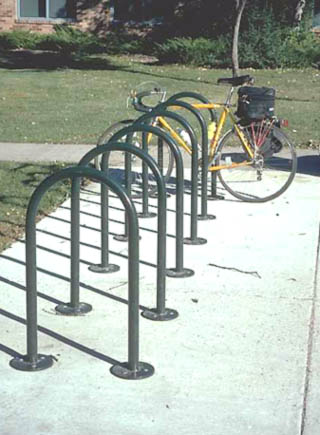

In [53]:
Image.open("./dataset/GQA/img/1072.jpg")

In [ ]:
sg = SCENE_GRAPH['1159835']

colors = ["red", "orange", "blue", "green", "cyan", "pink", "yellow"]
names = []

box = []
i = 0
for _,v in sg["objects"].items():
    x,y,w,h = v["x"], v["y"], v["w"], v["h"]
    box.append([x, y, x+w, y+h])
    names.append(v["name"])
    
    i += 1
    if i == 7:
        break
box = torch.tensor(box, dtype=torch.int) 

img = draw_bounding_boxes(IMG_2, box, width=3, colors=colors) 
  
# transform this image to PIL image 
img = torchvision.transforms.ToPILImage()(img) 
img.show()

In [98]:
names

['door', 'ornament', 'television', 'ornament', 'ornament', 'ornament', 'tie']

In [63]:
import torch
from PIL import Image
import random
import numpy as np
import torch
from transformers import LlavaForConditionalGeneration, VipLlavaForConditionalGeneration, AutoModel, AutoProcessor, AutoModelForCausalLM, AutoModelForPreTraining

def set_seed(seed: int) -> None:
    """
    Set the seed for random number generators for reproducibility.

    Args:
    - seed (int): The seed value.
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)


def load_model(model_path, model_family, low_cpu_mem_usage, device = "cuda", seed = 42):
    
    MODEL_LOADER_DICT = {
        "llava" : LlavaForConditionalGeneration,
        "vip_llava": VipLlavaForConditionalGeneration,
        "auto": AutoModel,
        "llama": AutoModelForCausalLM,
        "llava-1.6": AutoModelForPreTraining
    }
    
    model, processor = None, None
    if "openai" not in model_family:
        set_seed(seed)
        model = MODEL_LOADER_DICT[model_family].from_pretrained(
            model_path,
            torch_dtype = torch.float16,
            low_cpu_mem_usage = low_cpu_mem_usage
        ).to(device)
        processor = AutoProcessor.from_pretrained(model_path)
        
    print(f"Loaded {model_path}")
    
    return model, processor


In [42]:
model, processor = load_model("llava-hf/vip-llava-13b-hf", "vip_llava", 1)

Loading checkpoint shards: 100%|██████████| 6/6 [00:01<00:00,  4.54it/s]
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Loaded llava-hf/vip-llava-13b-hf


In [69]:
# Inference helpers
def inference_hf(
    model, processor,
    prompt, api_key=None, boilerplate_prompt=True,
    img_path=None, img_raw=None, 
    max_new_tokens=1500, do_sample=False, skip_special_tokens=True) -> (str, float):

    if img_raw is None:
        try:
            img_raw = Image.open(img_path)
        except Exception as e:
            return str(e)
    
    if boilerplate_prompt:    
        prompt = "USER: <image>\n" + prompt + "\nASSISTANT:"
    
    inputs = processor(prompt, img_raw, return_tensors='pt').to(0, torch.float16)
    raw_output = model.generate(**inputs, max_new_tokens=max_new_tokens, do_sample=do_sample)
    output = processor.decode(raw_output[0], skip_special_tokens=skip_special_tokens)
    
    if boilerplate_prompt:
        output = output[output.index("ASSISTANT:") + 11:]
    
    return output+"\n"

In [120]:
base_prompt = """
Generate questions that involves complex reasoning with an equal mix of 'WHAT,' 'WHERE', and 'WHO'. For each question, generate a short factoid answer and long answer that contains the reason of short answer pick.
    
What are {number} possible questions-answers about the image?

Present the question-answer pairs in format:
1. <QUESTION-1>
S. <SHORT-ANSWER-1>
L. <LONG-ANSWER-1>
<<line-break>>
"""

vit_prompt = """
Generate {number} questions that involves complex reasoning using about {name} object
in the {color} bounding box. 

Present the question-answer-reasons in format:
1. <QUESTION>
S. <SHORT-ANSWER>
L. <LONG-ANSWER>
"""

In [112]:
base_out = inference_hf(
    model, processor, 
    base_prompt.format(number = 3),
    img_raw = IMG_2
)

In [113]:
print(base_out)

1. What is the purpose of the Christmas tree in the living room?
S. To celebrate Christmas.
L. The Christmas tree is a traditional symbol of the Christmas holiday season, typically decorated with lights, ornaments, and a star or an angel on top to represent the Star of Bethlehem. It is often used as a centerpiece for holiday festivities and is meant to bring joy and spread holiday cheer to those who see it.
<<line-break>>
2. What is the function of the television in the living room?
S. To watch shows or movies.
L. The television is an electronic device used for entertainment, such as watching TV shows, movies, or playing video games. It is a common appliance in living rooms as it provides a source of entertainment for the occupants and their guests.
<<line-break>>
3. Who is likely to be present in the living room during the holiday season?
S. Family and friends.
L. During the holiday season, it is common for families and friends to gather in the living room to celebrate Christmas, exch

In [126]:
from tqdm import tqdm
out = ""

COL = [i for i in range(len(names))]

for obj_i in tqdm(COL):
    vit_out = inference_hf(
        model, processor, 
        vit_prompt.format(
            number = 1,
            name = names[obj_i], 
            color = colors[obj_i]
        ),
        img_raw = img
    )
    out += vit_out + "------------------------------------\n"

100%|██████████| 7/7 [00:27<00:00,  3.94s/it]


In [127]:
print(out)

1. What is the purpose of the door within red bounding box?
S. To provide access to the outside.
L. The door within red bounding box is a traditional wooden door that likely leads to a porch or deck, providing a means for people to enter and exit the house.
------------------------------------
1. What is the significance of the ornament within the orange bounding box on the Christmas tree within the red rectangle?
S. It is a decoration.
L. The ornament within the orange bounding box is a decorative item that is commonly used to adorn Christmas trees within the red rectangle during the holiday season. It adds a festive touch to the tree and is often chosen for its color, shape, or theme.
------------------------------------
1. What is the name of the movie playing on the television within blue bounding box?
S. Star Wars
L. The movie playing on the television within blue bounding box is Star Wars, as indicated by the visible logo and the spacecraft visible on the screen.
----------------